In [ ]:
from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import numpy as np
import torch
from diffusers.utils import load_image

In [45]:
depth_estimator = pipeline('depth-estimation')

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [46]:
image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-depth/resolve/main/images/stormtrooper.png")

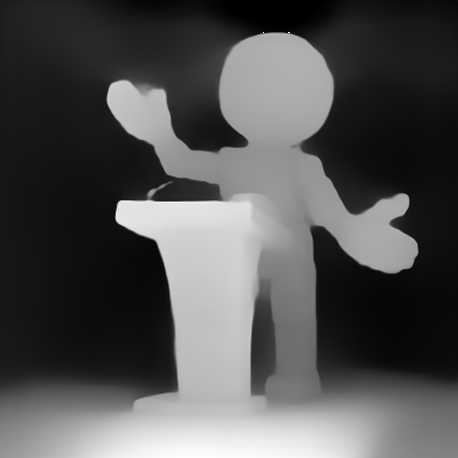

In [63]:
depth = depth_estimator(image)['depth']
depth_arr = np.array(depth)
depth_arr = depth_arr[:, :, None]
depth_arr = np.concatenate([depth_arr, depth_arr, depth_arr], axis=2)
depth_img = Image.fromarray(depth_arr)

depth_img

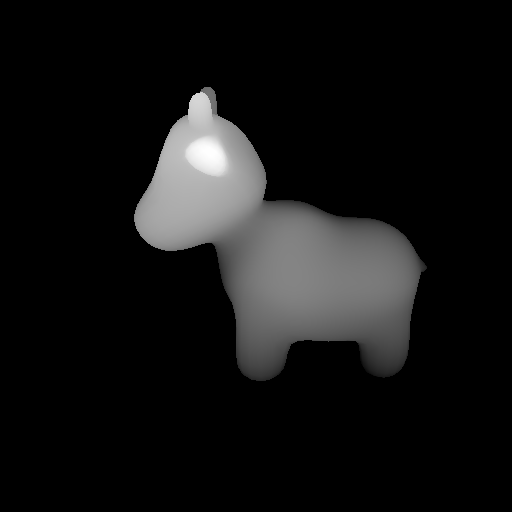

In [129]:
from einops import rearrange

my_depth = torch.load('data/depth.pt')
my_depth = rearrange(my_depth, '1 h w c -> c h w')

# depth_map_min = my_depth.min()
# depth_map_max = my_depth.max()
# depth_map_normalized = (my_depth - depth_map_min) / (depth_map_max - depth_map_min)

from diffusion import process_depth_map

depth_map_normalized = process_depth_map(my_depth)

# Convert to grayscale (0-255) and ensure it's in uint8 format
depth_map_grayscale = (depth_map_normalized * 255).to(torch.uint8)

depth_map_grayscale.dtype

import torchvision.transforms as transforms

transform_to_pil = transforms.ToPILImage()
grayscale_image = transform_to_pil(depth_map_grayscale)
grayscale_image

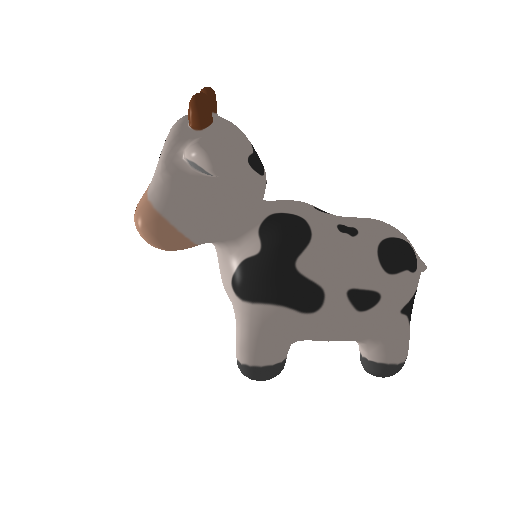

In [130]:
my_img = torch.load('data/render.pt')
my_img = rearrange(my_img, '1 h w c -> c h w')

my_img = (my_img * 255).to(torch.uint8)
transform_to_pil = transforms.ToPILImage()
my_img_pil = transform_to_pil(my_img)
my_img_pil

In [131]:
device = 'cuda'
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16
).to(device)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
).to(device)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:  17%|█▋        | 1/6 [00:00<00:00,  9.30it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all publ

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


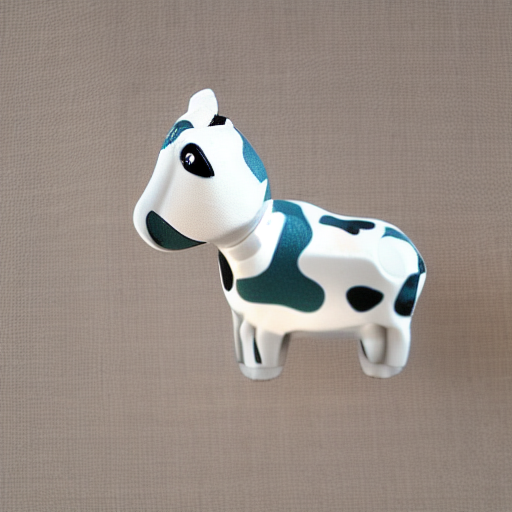

In [141]:
prompt = 'toy cow'

image = pipe(
    f'{prompt}, best quality, highly detailed, photorealistic, photo',
    neg_prompt='lowres, low quality, monochrome, watermark',
    image=my_img_pil, 
    control_img=grayscale_image,
    guidance_scale=9,
    eta=1,
    num_inference_steps=20
    ).images[0]

image